In [1]:
%matplotlib notebook

import sys
import os
import time
from importlib import reload

In [2]:
import numpy as np
import qcodes as qc
import broadbean as bb

from matplotlib import pyplot as plt
from broadbean.plotting import plotter

In [3]:
from qcodes.instrument.base import Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter

In [4]:
from pytopo.qctools import instruments as instools; reload(instools)
from pytopo.qctools.instruments import create_inst, add2station

from pytopo.qctools import measurement; reload(measurement)
from pytopo.qctools.measurement import MeasurementExt

from pytopo.mplplots.init_nb_plotting import *
from pytopo.mplplots import plots as mplplots
from pytopo.mplplots import tools as mpltools

In [5]:
import plottr; reload(plottr)

from pytopo.qctools.dataset2 import select_experiment
from plottr.qcodes_dataset import QcodesDatasetSubscriber

# Init

## Tools

In [6]:
from pytopo.qctools import hard_sweep; reload(hard_sweep)
from pytopo.qctools.hard_sweep import HardSweep, HardSweepDetector

In [7]:
# from qcodes.instrument.base import Instrument

# class IFController(Instrument):
    
#     def __init__(self, name, rf_inst, lo_inst, **kw):
#         super().__init__(name, **kw)
        
#         self.rf = rf_inst
#         self.lo = lo_inst
        
#         pass

### Pulse sequencer

In [8]:
ramp = bb.PulseAtoms.ramp

class BluePrints(object):
    
    def __init__(self, chan_map, sample_rate=1e9):
        self.bps = {}
        self.map = {}
        
        for i, lst in chan_map.items():
            self.bps[i] = bb.BluePrint()
            self.bps[i].setSR(sample_rate)
            for j, name in enumerate(lst):
                if name is not None:
                    self.map[name] = (i, j)
                    
    def __getitem__(self, name):
        if self.map[name][1] == 0:
            return self.bps[self.map[name][0]]
        else:
            return getattr(self.bps[self.map[name][0]], 'marker{}'.format(self.map[name][1]))
        
    def __setitem__(self, name, value):
        if self.map[name][1] == 0:
            self.bps[self.map[name][0]] = value
        else:
            setattr(self.bps[self.map[name][0]], 'marker{}'.format(self.map[name][1]), value)
        
    def __call__(self):
        return list(self.bps.items())
    

class BroadBeanSequence(HardSweep):
    
    chan_map = {}
    
    def __init__(self, name, awg, chan_map, **kw):
        self.awg = awg
        self.chan_map = chan_map
        
        super().__init__(name, **kw)
        
        self.add_parameter('sample_rate', get_cmd=None, set_cmd=None, 
                           unit='GS/s', initial_value=1e9)
        
    def sequence(self):
        raise NotImplementedError
        
        
    def setup(self, program_awg=True, start_awg=True):
        super().setup()
        
        self.awg.stop()
        
        if program_awg:
            self.awg.clock_freq(self.sample_rate())
            seq = self.sequence()
            pkg = seq.outputForAWGFile()
            self.awg.make_send_and_load_awg_file(*pkg[:])
        
            for ch_no, ch_desc in self.chan_map.items():
                self.awg.set('ch{}_state'.format(ch_no), 1)

        if start_awg:
            self.awg.start()

        
class SimpleAWGSpec(BroadBeanSequence):

    def __init__(self, *arg, **kw):
        
        kw['sweep_dims'] = ['awg_sweep_idx', ]
        
        super().__init__(*arg, **kw)
        
        self.add_parameter('initial_delay', set_cmd=None,
                           unit='s', initial_value=1e-6)
        self.add_parameter('alazar_trigger_len', set_cmd=None,
                           unit='s', initial_value=1e-7)
        self.add_parameter('alazar_trigger_delay', set_cmd=None, 
                           unit='s', initial_value=1e-6)
        self.add_parameter('seq_len', set_cmd=None, 
                           unit='s', initial_value=1e-5)
        self.add_parameter('final_delay', set_cmd=None,
                           unit='s', initial_value=1e-6)

    def setup(self, **kw):
        self.awg_sweep_idx([1,])
        super().setup(**kw)
        
    def sequence(self):
        elem = bb.Element()
        
        bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())
        
        bps['ro'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='ro_segment')
        bps['alz_mrkr'] = [(self.initial_delay(), self.alazar_trigger_len())]
        bps['ro_mrkr'] = [(self.initial_delay() + self.alazar_trigger_delay(), 
                           self.seq_len() - self.initial_delay() - 2 * self.alazar_trigger_delay() - self.final_delay(), )]
        
        bps['q'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='q_segment')
        bps['q_mrkr'] = [(self.initial_delay() + self.alazar_trigger_delay(), 
                          self.seq_len() - self.initial_delay() - 2 * self.alazar_trigger_delay() - self.final_delay(), )]
        
        
        for n, bp in bps():
            elem.addBluePrint(n, bp)
            
        seq = bb.Sequence()
        seq.name = 'spec'
        seq.addElement(1, elem)
        seq.setSR(self.sample_rate())
        
        seq.setChannelAmplitude(1, 1)
        seq.setChannelOffset(1, 0)
        seq.setChannelAmplitude(2, 1)
        seq.setChannelOffset(2, 0)

        seq.setSequencingTriggerWait(1, 0)
        seq.setSequencingGoto(1, 1)
        
        return seq

### Alazar Detector

In [9]:
class AlazarBaseDetector(HardSweepDetector):
    
    def __init__(self, name, acqctl, sweep_params=['buffers', 'records'], **kwargs):
        self.acqctl = acqctl        
        self._time = None
        self._signal_real = None
        self._signal_imag = None
        self._signal_abs = None

        inner_dims = []
        for d in self.acqctl.data_dims():
            if d not in sweep_params:
                inner_dims.append(d)
        
        super().__init__(name, inner_dims=inner_dims, **kwargs)
        
        self.add_parameter('acquisition', get_cmd=self.do_acquisition, unit='V', snapshot_value=False)
        self.add_parameter('signal_real', get_cmd=lambda: self._signal_real, unit='V', snapshot_value=False)
        self.add_parameter('signal_imag', get_cmd=lambda: self._signal_imag, unit='V', snapshot_value=False)
        self.add_parameter('signal_abs', get_cmd=lambda: self._signal_abs, unit='V', snapshot_value=False)
        self.data_params = [self.signal_real, self.signal_imag, self.signal_abs]
        
        if 'samples' in self.inner_dims or 'IF_periods' in self.inner_dims:
            self.add_parameter('time', unit='s', snapshot_value=False, 
                               get_cmd=lambda: self._time)

    def setup(self):
        ### TODO:
        # We should have an option that it's possible to not specify all dimensions,
        # and basically set the shape to (-1, xxx), i.e., set the first one automatic.
        # that might then be an implicit averaging dimension, for example.
        # then sweepers can be used for both avering over buffers, or single-shot        
        for d in self.inner_dims:
            idx = self.acqctl.data_dims().index(d)
            try:
                npts = self.acqctl.data_shape()[idx]
            except:
                npts = 1
            self.set(d, np.arange(npts))
            
        super().setup()
    
    
    def do_acquisition(self):
        data = self.acqctl.acquisition()
        self.setup()
        
        if 'samples' in self.inner_dims:
            self._time = self.acqctl.tvals
        elif 'IF_periods' in self.inner_dims:
            self._time = self.acqctl.demod_tvals
            
        self._signal_real = np.real(data)
        self._signal_imag = np.imag(data)
        self._signal_abs = np.abs(data)
        
        return data

    
class AlazarDetector(AlazarBaseDetector):
    
    def __init__(self, name, acqctl, **kwargs):
        kwargs['sweep_params'] = ['buffers', 'records']
        
        super().__init__(name, acqctl, **kwargs)
        
        self.add_parameter('avg_buffers', set_cmd=None, initial_value=True)
        self.add_parameter('acq_time', 
                           get_cmd=lambda: self.acqctl.acq_time(), 
                           set_cmd=lambda x: self.acqctl.acq_time(x))
        
        if hasattr(self.acqctl, 'demod_frq'):
            self.add_parameter('demod_frq', 
                               get_cmd=lambda: self.acqctl.demod_frq(), 
                               set_cmd=lambda x: self.acqctl.demod_frq(x))
        
    def configure_alazar(self, **kwargs):
        defaults = dict(
            buffer_timeout = 10000,
            allocated_buffers = 1,
        )
        defaults.update(kwargs)
        self.acqctl.update_acquisitionkwargs(**defaults)
        
    def do_acquisition(self):
        data = super().do_acquisition()
        
        if self.avg_buffers():
            bidx = self.acqctl.data_dims().index('buffers')
            data = data.mean(axis=bidx)
            
            self._signal_real = np.real(data)
            self._signal_imag = np.imag(data)
            self._signal_abs = np.abs(data)
            
        return data

### Heterodyne source

In [10]:
class HeterodyneSource(Instrument):
    
    def __init__(self, name, RF, LO, *arg, **kw):
        super().__init__(name, *arg, **kw)
        
        self.RF = RF
        self.LO = LO
        
        self.add_parameter('IF', set_cmd=None, initial_value=20e6)
        self.add_parameter('frequency', unit='Hz',
                           get_cmd=self.RF.frequency, 
                           set_cmd=self._set_freq)
        
        self.frequency(self.frequency())
    
    def _set_freq(self, frq):
        self.RF.frequency(frq)
        self.LO.frequency(frq-self.IF())
        

## load instruments

In [11]:
# %run init_cQED.py

In [75]:
### Init instruments
from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
from pytopo.rf.alazar_acquisition import RawAcqCtl, AvgBufCtl, AvgDemodCtl, AvgIQCtl, DemodAcqCtl, IQAcqCtl
# , DemodRelAcqCtl, IQRelAcqCtl, IQAcqCtl

inst_list = []

from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar')
inst_list.append(alazar)

raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
inst_list.append(raw_acq)

avg_acq = instools.create_inst(AvgBufCtl, 'avg_acq', 'alazar', force_new_instance=True)
inst_list.append(avg_acq)

avgdemod_acq = instools.create_inst(AvgDemodCtl, 'avgdemod_acq', 'alazar', force_new_instance=True)
inst_list.append(avgdemod_acq)

avgiq_acq = instools.create_inst(AvgIQCtl, 'avgiq_acq', 'alazar', force_new_instance=True)
inst_list.append(avgiq_acq)

demod_acq = instools.create_inst(DemodAcqCtl, 'demod_acq', 'alazar', force_new_instance=True)
inst_list.append(demod_acq)

# demodrel_acq = instools.create_inst(DemodRelAcqCtl, 'rel_acq', 'alazar', force_new_instance=True)
# inst_list.append(demodrel_acq)

# iqrel_acq = instools.create_inst(IQRelAcqCtl, 'iqrel_acq', 'alazar', force_new_instance=True)
# inst_list.append(iqrel_acq)

iq_acq = instools.create_inst(IQAcqCtl, 'iq_acq', 'alazar', force_new_instance=True)
inst_list.append(iq_acq)

from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg5014 = instools.create_inst(Tektronix_AWG5014, 'awg5014', address="TCPIP0::169.254.220.147::inst0::INSTR")
inst_list.append(awg5014)

from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.2.20")
inst_list.append(LO)

RF = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.231.38")
inst_list.append(RF)

qubit_gen = instools.create_inst(RohdeSchwarz_SGS100A, 'qubit_gen', address="TCPIP0::169.254.167.18")
inst_list.append(qubit_gen)

het_src = instools.create_inst(HeterodyneSource, 'het_src', LO=LO, RF=RF)
inst_list.append(het_src)

# from qcodes.instrument_drivers.yokogawa.GS200 import GS200
# yoko = instools.create_inst(GS200, 'yoko', address="TCPIP0::169.254.1.9::inst0::INSTR")
# inst_list.append(yoko)


Instrument alazar already exists.
Instrument raw_acq already exists.
Instrument avg_acq already exists.
Instrument avgdemod_acq already exists.
Instrument avgiq_acq already exists.
Instrument demod_acq already exists.
Instrument iq_acq already exists.
Instrument awg5014 already exists.
Instrument LO already exists.
Instrument RF already exists.
Instrument qubit_gen already exists.
Instrument het_src already exists.


In [76]:
from qcodes.instrument_drivers.Minicircuits.RUDAT_13G_90 import RUDAT_13G_90_USB
ro_attenuator = instools.create_inst(RUDAT_13G_90_USB, 'ro_attenuator')
inst_list.append(ro_attenuator)

Instrument ro_attenuator already exists.


In [77]:
station = qc.Station(*inst_list)

## Global settings

In [78]:
SAMPLE = 'ref_transmon_CD20180510'
AWG_CHANS = {
        1 : ['ro', 'alz_mrkr', 'ro_mrkr'],
        2 : ['q', 'q_mrkr', None],
    }

IF = 20e6

het_src.IF(IF)
het_src.frequency(het_src.frequency())

LO.power(13)
RF.power(10)

## Meta instruments for sweeping

In [79]:
# create the meta-instrument for the sequence, add to the qcodes station.
awg_spec_sweep = create_inst(SimpleAWGSpec, 'awg_spec_sweep', awg=awg5014, chan_map=AWG_CHANS, force_new_instance=True)
station = add2station(station, awg_spec_sweep)

# meta-instrument for the detector (i.e., alazar acquisition)
# iqrel_detector = create_inst(AlazarDetector, name='iqrel_detector', acqctl=iqrel_acq, force_new_instance=True)
# station = add2station(station, iqrel_detector)

# demodrel_detector = create_inst(AlazarDetector, name='demodrel_detector', acqctl=demodrel_acq, force_new_instance=True)
# station = add2station(station, demodrel_detector)

avg_detector = create_inst(AlazarDetector, name='avg_detector', 
                           acqctl=avg_acq, force_new_instance=True)
station = add2station(station, avg_detector)

avgdemod_detector = create_inst(AlazarDetector, name='avgdemod_detector', 
                                acqctl=avgdemod_acq, force_new_instance=True)
station = add2station(station, avgdemod_detector)

avgiq_detector = create_inst(AlazarDetector, name='avgiq_detector', 
                             acqctl=avgiq_acq, force_new_instance=True)
station = add2station(station, avgiq_detector)

iq_detector = create_inst(AlazarDetector, name='iq_detector', acqctl=iq_acq, force_new_instance=True)
station = add2station(station, iq_detector)

Instrument awg_spec_sweep already exists.
Instrument avgdemod_detector already exists.
Instrument avgiq_detector already exists.
Instrument iq_detector already exists.


## Default acquisition settings

In [80]:
### Configure ATS settings

ats_settings = dict(
    clock_source='INTERNAL_CLOCK',
    sample_rate=int(2e8),
    clock_edge='CLOCK_EDGE_RISING',
    decimation=1,
    coupling=['DC','DC'],
    channel_range=[.4, .4],
    impedance=[50, 50],
    trigger_operation='TRIG_ENGINE_OP_J',
    trigger_engine1='TRIG_ENGINE_J',
    trigger_source1='EXTERNAL',
    trigger_slope1='TRIG_SLOPE_POSITIVE',
    trigger_level1=128+20,
    trigger_engine2='TRIG_ENGINE_K',
    trigger_source2='DISABLE',
    trigger_slope2='TRIG_SLOPE_POSITIVE',
    trigger_level2=128+5,
    external_trigger_coupling='DC',
    external_trigger_range='ETR_2V5',
    trigger_delay=0,
    timeout_ticks=int(1e7),
    aux_io_mode='AUX_IN_AUXILIARY',
    aux_io_param='NONE',
)

station.alazar.config(**ats_settings)


### Trigger the acquisition controllers

def trigger_func(do_start):
    if do_start:
        station.awg5014.start()
    else:
        station.awg5014.stop()

for ctl in [iq_acq, avgdemod_acq, avgiq_acq]:
    ctl.trigger_func = trigger_func
    ctl.demod_frq(IF)
    
for det in [iq_detector, avgdemod_detector, avgiq_detector]:
    det.demod_frq(IF)

# Signal testing

## Transmission (time-signal)

In [20]:
awg_spec_sweep.sample_rate(1e9)
# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
awg_spec_sweep.seq_len(10e-6)
# and setup the sequence (will program the awg)
awg_spec_sweep.setup()

In [21]:
### Set up the detector

# set the sweeper
det = avgdemod_detector
det.avg_buffers(False)

det.set_sweeper(awg_spec_sweep)
# acquisition time
det.acq_time(awg_spec_sweep.seq_len() - 1e-6)
# demod frequency
det.demod_frq(IF)
# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=100,
)
det.setup()

print(det.sweep_dims, det.sweep_shape)

['awg_sweep_idx', 'IF_periods', 'channels'] (1, 1, 1)


In [24]:
data = det.acquisition()
data.shape, det.sweep_shape

((1, 192, 2), (1, 192, 2))

<IPython.core.display.Javascript object>


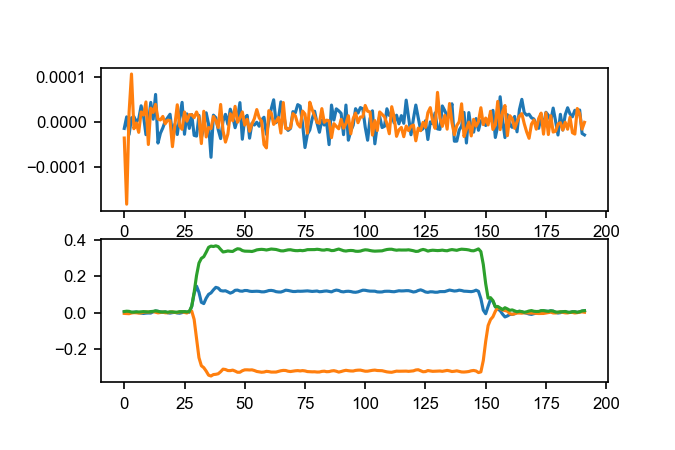

In [25]:
fig, axes = plt.subplots(2, 1)

ax = axes[0]
ax.plot(data[0, :, 0].real)
ax.plot(data[0, :, 0].imag)

ax = axes[1]
ax.plot(data[0, :, 1].real)
ax.plot(data[0, :, 1].imag)
ax.plot(np.abs(data[0, :, 1]))

## Noise level and spectrum

In [145]:
ro_attenuator.attenuation(40)
het_src.frequency(7.14e9)

In [126]:
awg_spec_sweep.sample_rate(1e7)
# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
awg_spec_sweep.seq_len(500e-3)
# and setup the sequence (will program the awg)
awg_spec_sweep.setup()

In [121]:
### Set up the detector

# set the sweeper
# det = avgdemod_detector
det = avg_detector
det.avg_buffers(False)

det.set_sweeper(awg_spec_sweep)
# acquisition time
det.acq_time(100e-3)
# demod frequency
# det.demod_frq(IF)
# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=1,
)
det.setup()

print(det.sweep_dims, det.sweep_shape)

['awg_sweep_idx', 'samples', 'channels'] (1, 20000000, 2)


In [156]:
data = det.acquisition()
data.shape, det.sweep_shape

((1, 20000000, 2), (1, 20000000, 2))

<IPython.core.display.Javascript object>


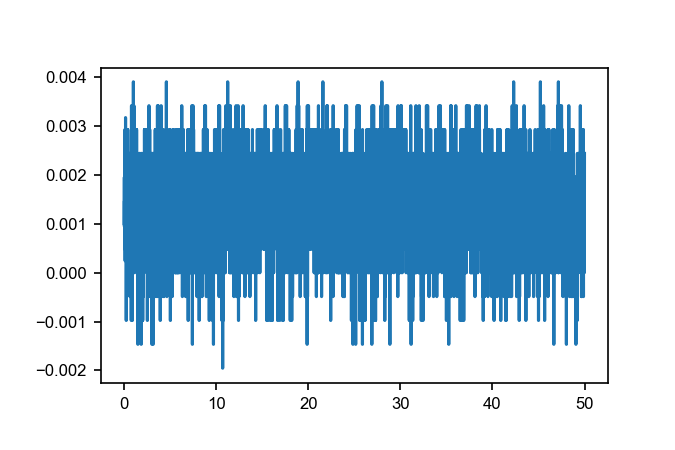

In [157]:
fig, axes = plt.subplots(1, 1)

ax = axes
ax.plot(det.time()[:10000]*1e6, data[0, :10000, 1])
# ax.plot(data[0, :, 1].imag)
# ax.plot(np.abs(data[0, :, 1]))

<IPython.core.display.Javascript object>


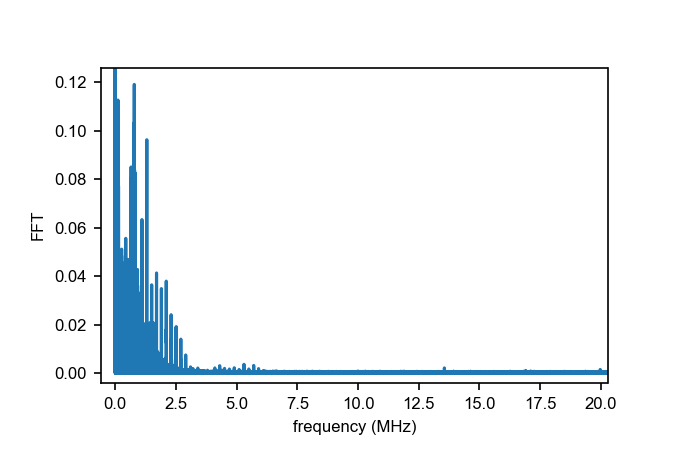

Text(0,0.5,'FFT')

In [158]:
ffty = np.fft.rfft(data[0, :, 1].real)
fftx = np.fft.rfftfreq(data[0, :, 1].size, d=5e-9)

PSD = abs(ffty) / (data[0, :, 1].size)**.5 / (10.)**.5

fig, ax = plt.subplots(1, 1)
ax.plot(fftx[10:] * 1e-6, PSD[10:])
ax.set_xlabel('frequency (MHz)')
ax.set_ylabel('FFT')

# CW spec

## RO spec

### Experiment settings

In [34]:
# demod frequency
IF = 20e6

# experiment name
exp = select_experiment('readout_spec', SAMPLE)

# averaging
navgs = 1000

# Spectroscopy frequencies
rf_frqs = np.linspace(7.145e9, 7.155e9, 201)[:]

# power
ro_attenuator.attenuation(0)

# Flux
# yoko.on()
# yoko.ramp_voltage(0.0, 1e-3, 0.01)

In [35]:
### Set up the Sweeper

# AWG sampling rate (in Hz)
awg_spec_sweep.sample_rate(1e9)
# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
awg_spec_sweep.seq_len(100e-6)
# and setup the sequence (will program the awg)
awg_spec_sweep.setup()

In [36]:
### Set up the detector

# det = iq_detector
# det = iqrel_detector
det = avgiq_detector
det.avg_buffers(False)

# set the sweeper
det.set_sweeper(awg_spec_sweep)
# acquisition time
det.acq_time(awg_spec_sweep.seq_len() - 2e-6)
# demod frequency
det.demod_frq(IF)
# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=navgs,
)
det.setup()

print(det.sweep_dims, det.sweep_shape)

['awg_sweep_idx', 'channels'] (1, 2)


### Run

In [38]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          het_src.frequency,
                          ro_attenuator.attenuation,
                      ])

# the measurement loop
meas.write_period = 1
with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    
    for att in np.arange(50, 80, 5):
        ro_attenuator.attenuation(att)
    
        for f in rf_frqs:
            het_src.frequency(f)
            time.sleep(0.01)

            det.acquisition()
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 282


## Qubit Spec

### Basic config

In [41]:
# demod frequency
IF = 20e6
# Readout frq
het_src.frequency(7.1508e9)
het_src.IF(20e6)
# experiment name
exp = select_experiment('qubit_spec', SAMPLE)
# averages
navgs = 1000
# spec frqs
q_frqs = np.linspace(5.2e9, 5.5e9, 151)
# ro power
ro_attenuator.attenuation(50)

### Sweeper and detector

In [40]:
### SWEEPER
# AWG sampling rate (in Hz)
awg_spec_sweep.sample_rate(1e9)
# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
awg_spec_sweep.seq_len(100e-6)
# and setup the sequence (will program the awg)
awg_spec_sweep.setup()


### DETECTOR
# det = iqrel_detector
det = avgiq_detector
det.avg_buffers(False)

# set the sweeper
det.set_sweeper(awg_spec_sweep)
# acquisition time
det.acq_time(awg_spec_sweep.seq_len() - 2e-6)
# demod frequency
det.demod_frq(IF)
# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=navgs,
)
det.setup()

print(det.sweep_dims, det.sweep_shape)

['awg_sweep_idx', 'channels'] (1, 2)


### Run

In [51]:
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          qubit_gen.frequency,
                          ro_attenuator.attenuation,
                      ])

# the measurement loop
meas.write_period = 1
with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    
    for att in 10 * np.log10(np.linspace(1e5, 1e6, 11)):
        ro_attenuator.attenuation(att)
    
        for f in q_frqs:
            qubit_gen.frequency(f)
            time.sleep(0.01)

            det.acquisition()
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 284


0.025000000000000355

# TD Experiments

## Some Testing

### Define tools

In [ ]:
class TDTestSequence(BroadBeanSequence):

    def __init__(self, *arg, **kw):
        
        kw['sweep_dims'] = ['averages', 'ro_length', ]
        kw['sweep_units'] = ['', 's', ]
        
        super().__init__(*arg, **kw)
        
        self.add_parameter('initial_delay', set_cmd=None,
                           unit='s', initial_value=1e-6)
        self.add_parameter('alazar_trigger_len', set_cmd=None,
                           unit='s', initial_value=1e-7)
        self.add_parameter('alazar_trigger_delay', set_cmd=None, 
                           unit='s', initial_value=1e-6)
        self.add_parameter('seq_len', set_cmd=None, 
                           unit='s', initial_value=1e-5)
        
        self.add_parameter('start_len', set_cmd=None, unit='s', initial_value=1e-6)
        self.add_parameter('stop_len', set_cmd=None, unit='s', initial_value=5e-6)
        self.add_parameter('len_pts', set_cmd=None, initial_value=5)
        self.add_parameter('n_averages', set_cmd=None, initial_value=1)

    def setup(self, **kw):
        self.averages(np.arange(self.n_averages()))
        self.ro_length(np.linspace(self.start_len(), self.stop_len(), self.len_pts()))
        super().setup(**kw)
        
    def sequence(self):
        elem = bb.Element()
        seq = bb.Sequence()
        seq.name = 'td_test'
        
        for i, length in enumerate(self.ro_length()):
            bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())
            bps['ro'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='ro_segment'.format(i))
            bps['alz_mrkr'] = [(self.initial_delay(), self.alazar_trigger_len())]
            bps['ro_mrkr'] = [(self.initial_delay() + self.alazar_trigger_delay(), length, )]
            bps['q'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='q_segment'.format(i))

            for n, bp in bps():
                elem.addBluePrint(n, bp)
        
            seq.addElement(i+1, elem)
            
            seq.setSequencingTriggerWait(i+1, 0)
            seq.setSequencingGoto(i+1, (i+2)%self.len_pts())
        
        
        seq.setSR(self.sample_rate())
        
        seq.setChannelAmplitude(1, 1)
        seq.setChannelOffset(1, 0)
        seq.setChannelAmplitude(2, 1)
        seq.setChannelOffset(2, 0)

        return seq
    

# channel map. note that at this moment the analog channels are required, even if we don't do anything with them.
awg_chan_map = {
        1 : ['ro', 'alz_mrkr', 'ro_mrkr'],
        2 : ['q', 'q_mrkr', None],
    }

# create the meta-instrument for the sequence, add to the qcodes station.
td_test_sweep = create_inst(TDTestSequence, 'td_test_sweep', awg=awg5014, chan_map=awg_chan_map, force_new_instance=True)
station = add2station(station, td_test_sweep)

# create the detector instrument
# ctl = demodrel_acq
ctl = iqrel_acq
td_test_detector = create_inst(AlazarDetector, name='td_test_detector', acqctl=ctl, 
                               sweep_params=['buffers', 'records',], force_new_instance=True)

station = add2station(station, td_test_detector)

### Configure experiments

In [ ]:
exp = select_experiment('TD_test', SAMPLE)

# set generators to RF frq
IF = 20e6
RF.frequency(7.15e9)
LO.frequency(RF.frequency() + IF)
awg5014.stop()

### Configure the AWG sweep

# AWG sampling rate (in Hz)
td_test_sweep.sample_rate(1e9)

# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
td_test_sweep.seq_len(100e-6)
td_test_sweep.start_len(10e-6)
td_test_sweep.stop_len(50e-6)
td_test_sweep.len_pts(6)
td_test_sweep.n_averages(10)

# and setup the sequence (will program the awg)
td_test_sweep.setup(start_awg=False, program_awg=True)


### Configure the detector
td_test_detector.set_sweeper(td_test_sweep)

# setup acquisition controller and detector
def trigger_func(do_start):
    if do_start:
        station.awg5014.start()
    else:
        pass

ctl.trigger_func = trigger_func

# Configure Alazar acquisition controller
# acquisition time
ctl.acq_time(80e-6)

# demod frequency
ctl.demod_frq(IF)

# HW config, and how data is shaped.
ctl.update_acquisitionkwargs(
    # the sweep is now encoded in the records
    records_per_buffer=td_test_sweep.len_pts(), 
    
    # this is for averaging by repeating the sequence; ie, number of averages per 'shot'.
    buffers_per_acquisition=td_test_sweep.n_averages(),
    
    # leave as is for now.
    buffer_timeout=10000,
    allocated_buffers=1
)

# setup the detector
td_test_detector.setup()

In [ ]:
print(td_test_detector.sweep_dims, td_test_detector.sweep_shape)

In [ ]:
# after setting up, we can create the measurement object.
meas = hard_sweep.make_measurement('results', exp=exp, 
                                   hard_sweep_detector=td_test_detector,)

# the measurement loop
with meas.run() as datasaver:
    td_test_detector.acquisition()
        
    # add to dataset
    result = td_test_detector.get_sweep_coords()

    # and add the data
    result += [(td_test_detector.signal_real, td_test_detector.signal_real().reshape(-1).astype(float))]
    result += [(td_test_detector.signal_imag, td_test_detector.signal_imag().reshape(-1).astype(float))]

    datasaver.add_result(*result)

In [ ]:
shape = td_test_detector.sweep_shape
print(shape)
ds = datasaver.dataset
print(ds)

sigr = np.array(ds.get_values('td_test_detector_signal_real')).reshape(shape)
sigi = np.array(ds.get_values('td_test_detector_signal_imag')).reshape(shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(((sigr**2 + sigi**2)**.5), aspect='auto')

## Pulsed qubit spec

### Measurement classes

In [ ]:
class PulsedQubitSpec(BroadBeanSequence):
    
    initial_delay = 1e-6
    alz_trigger_len = 100e-9
    alz_trigger_delay = 0

    def __init__(self, *arg, **kw):
        
        kw['sweep_dims'] = ['awg_sweep_idx', ]
        
        super().__init__(*arg, **kw)

        self.add_parameter('seq_len', set_cmd=None, unit='s',
                           initial_value=1e-5)
        self.add_parameter('readout_len', set_cmd=None, unit='s',
                           initial_value=2e-6)
        self.add_parameter('qubit_pulse_len', set_cmd=None, unit='s',
                           initial_value=1e-6)
        self.add_parameter('readout_delay', set_cmd=None, unit='s', initial_value=0)

    def setup(self, **kw):
        self.awg_sweep_idx([1,])
        super().setup(**kw)
        
    def sequence(self):
        elem = bb.Element()
        
        bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())
        
        bps['ro'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='ro_segment')
        bps['alz_mrkr'] = [(self.initial_delay + self.qubit_pulse_len() + self.readout_delay(), 
                            self.alz_trigger_len)]
        bps['ro_mrkr'] = [(self.initial_delay + self.qubit_pulse_len() + \
                               self.readout_delay() + self.alz_trigger_len + self.alz_trigger_delay, 
                           self.readout_len())]
        
        bps['q'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='q_segment')
        bps['q_mrkr'] = [(self.initial_delay, self.qubit_pulse_len())]
        
        for n, bp in bps():
            elem.addBluePrint(n, bp)
            
        seq = bb.Sequence()
        seq.name = 'spec'
        seq.addElement(1, elem)
        seq.setSR(self.sample_rate())
        
        seq.setChannelAmplitude(1, 1)
        seq.setChannelOffset(1, 0)
        seq.setChannelAmplitude(2, 1)
        seq.setChannelOffset(2, 0)

        seq.setSequencingTriggerWait(1, 0)
        seq.setSequencingGoto(1, 1)
        
        return seq

### Basic config

In [ ]:
# demod frequency
IF = 20e6

# Readout frq
RF.frequency(7.1508e9)
LO.frequency(RF.frequency() + IF)

# experiment name
exp = select_experiment('qubit_spec_pulsed', SAMPLE)
# averages
navgs = 10000

# qubit frequency list
q_frqs = np.linspace(5.37e9, 5.42e9, 101)

# ro power
ro_attenuator.attenuation(32)

# qubit power
qubit_gen.power(-10)

### Sweeper / detector

In [ ]:
### SWEEPER

# create the meta-instrument for the sequence, add to the qcodes station.
qspec_sweep = create_inst(PulsedQubitSpec, 'qspec_sweep', awg=awg5014, chan_map=AWG_CHANS, force_new_instance=True)
station = add2station(station, qspec_sweep)

# AWG sampling rate (in Hz)
qspec_sweep.sample_rate(1e9)

# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
qspec_sweep.seq_len(25e-6)
qspec_sweep.readout_len(8e-6)
qspec_sweep.qubit_pulse_len(2e-6)
qspec_sweep.readout_delay(-.1e-6)

# Quasi-CW
# qspec_sweep.seq_len(100e-6)
# qspec_sweep.readout_len(98e-6)
# qspec_sweep.qubit_pulse_len(98e-6)
# qspec_sweep.readout_delay(-98.1e-6)

# and setup the sequence (will program the awg)
qspec_sweep.setup(start_awg=True)

In [ ]:
### DETECTOR
det = iqrel_detector
# det = demodrel_detector

# set the sweeper
det.set_sweeper(qspec_sweep)

# acquisition time
det.acq_time(qspec_sweep.readout_len() + 1e-6)

# demod frequency
det.demod_frq(IF)

# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=navgs,
    allocated_buffers=1,
)
det.setup()

print(det.sweep_dims, det.sweep_shape)

In [ ]:
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          qubit_gen.power,
                          qubit_gen.frequency, 
                      ])

# how often we write to the database
meas.write_period = 1

# the measurement loop
with meas.run() as datasaver:
    
    # notify live plotter
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset),
        state=[], min_wait=0, min_count=1,
    )
    
    # software sweep of RF power
    for p in np.linspace(-10, 20, 7):
        qubit_gen.power(p)
 
        # software sweep of the RF frequency
        for f in q_frqs:
            qubit_gen.frequency(f)
            time.sleep(0.2)

            # this runs the Alazar, and returns demodulated data.
            det.acquisition()
            datasaver.add_result(*meas.get_result())

## Pulsed qubit spec with time dependence

### Basic config

In [ ]:
# demod frequency
IF = 20e6
# Readout frq
RF.frequency(7.151e9)
LO.frequency(RF.frequency() + IF)
# experiment name
exp = select_experiment('qubit_spec_pulsed_timetrace', SAMPLE)
# averages
navgs = 100000
# qubit frequency list
q_frqs = np.linspace(5.25e9, 5.35e9, 26)

### Sweeper / detector

In [ ]:
### SWEEPER

# create the meta-instrument for the sequence, add to the qcodes station.
qspec_sweep = create_inst(PulsedQubitSpec, 'qspec_sweep', awg=awg5014, chan_map=AWG_CHANS, force_new_instance=True)
station = add2station(station, qspec_sweep)

# AWG sampling rate (in Hz)
qspec_sweep.sample_rate(1e9)

# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
qspec_sweep.alz_trigger_delay = -1.1e-6
qspec_sweep.initial_delay = 2e-6
# qspec_sweep.seq_len(100e-6)
# qspec_sweep.readout_len(100e-6)
# qspec_sweep.qubit_pulse_len(20e-6)
# qspec_sweep.readout_delay(-21e-6)

# Quasi-CW
qspec_sweep.alz_trigger_delay = 0
qspec_sweep.initial_delay = 1e-6
qspec_sweep.seq_len(100e-6)
qspec_sweep.readout_len(98e-6)
qspec_sweep.qubit_pulse_len(98e-6)
qspec_sweep.readout_delay(-98e-6)

# and setup the sequence (will program the awg)
qspec_sweep.setup(start_awg=True)

In [ ]:
### DETECTOR
# det = iqrel_detector
det = demodrel_detector

# set the sweeper
det.set_sweeper(qspec_sweep)
# acquisition time
det.acq_time(qspec_sweep.readout_len() + 3e-6)
# demod frequency
det.demod_frq(IF)
# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=navgs,
    allocated_buffers=1,
)
det.setup()

print(det.sweep_dims, det.sweep_shape)

In [ ]:
# det.add_parameter('soft_avg', get_cmd=None, set_cmd=None, initial_value=0)

In [ ]:
meas = hard_sweep.make_measurement('results', exp=exp, 
                                   hard_sweep_detector=det,
                                   soft_sweep_params=[qubit_gen.frequency, ])

# how often we write to the database
meas.write_period = 1

# the measurement loop
with meas.run() as datasaver:
    # this enables live plotting with the plottr
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    
#     qubit_gen.on()
        
    # software sweep of the RF frequency
    for f in q_frqs:
        qubit_gen.frequency(f)
        time.sleep(0.2)

        # this runs the Alazar, and returns demodulated data.
        det.acquisition()

        # now that the data is here, we can pass the data to the dataset
        # get all sweep params in the right format (depends on the acquisition controller we use)
        # this is important so we know how to get data back in the right shape
        result = det.get_sweep_coords()

        # add also the soft sweep params...
        result += [(qubit_gen.frequency, f)]

        # and add the data
        result += [(det.signal_real, det.signal_real().reshape(-1).astype(float))]
        result += [(det.signal_imag, det.signal_imag().reshape(-1).astype(float))]
        result += [(det.signal_abs, det.signal_abs().reshape(-1).astype(float))]

        datasaver.add_result(*result)

## Qubit Rabi

### Measurement classes

In [ ]:
class RabiSequence(BroadBeanSequence):
    
    initial_delay = 1e-6
    alz_trigger_len = 100e-9
    alz_trigger_delay = 0

    def __init__(self, *arg, **kw):
        
        kw['sweep_dims'] = ['pulse_length', ]
        kw['sweep_units'] = ['s', ]
        
        super().__init__(*arg, **kw)
        self.add_parameter('seq_len', set_cmd=None, 
                           unit='s', initial_value=1e-5)
        
        self.add_parameter('start_len', set_cmd=None, unit='s', initial_value=0)
        self.add_parameter('stop_len', set_cmd=None, unit='s', initial_value=200e-9)
        self.add_parameter('len_pts', set_cmd=None, initial_value=21)
        self.add_parameter('readout_len', set_cmd=None, initial_value=2e-6)

    def setup(self, **kw):
        self.pulse_length(np.linspace(self.start_len(), self.stop_len(), self.len_pts()))
        super().setup(**kw)
        
    def sequence(self):
        elem = bb.Element()
        seq = bb.Sequence()
        seq.name = 'rabi'
        
        for i, length in enumerate(self.pulse_length()):
            bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())            
            bps['q'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='q_segment')
            bps['q_mrkr'] = [(self.initial_delay, length)]            
            bps['ro'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='ro_segment')
            bps['alz_mrkr'] = [(self.initial_delay+length, 
                                self.alz_trigger_len)]
            bps['ro_mrkr'] = [(self.initial_delay+length+self.alz_trigger_len+self.alz_trigger_delay, 
                               self.readout_len())]

            for n, bp in bps():
                elem.addBluePrint(n, bp)
        
            seq.addElement(i+1, elem)
            
            seq.setSequencingTriggerWait(i+1, 0)
            seq.setSequencingGoto(i+1, (i+2)%self.len_pts())
        
        
        seq.setSR(self.sample_rate())
        
        seq.setChannelAmplitude(1, 1)
        seq.setChannelOffset(1, 0)
        seq.setChannelAmplitude(2, 1)
        seq.setChannelOffset(2, 0)

        return seq

### Basic config 

In [ ]:
# demod frequency
IF = 20e6
# Readout frq
RF.frequency(7.1507e9)
LO.frequency(RF.frequency() + IF)
# qubit frq
qubit_gen.frequency(5.395e9)
qubit_gen.power(2)
# experiment name
exp = select_experiment('qubit_rabi', SAMPLE)
# averages
navgs = 10000

### Sweeper / detector

In [ ]:
### SWEEPER

# create the meta-instrument for the sequence, add to the qcodes station.
rabi_sweep = create_inst(RabiSequence, 'rabi_sweep', awg=awg5014, chan_map=AWG_CHANS, force_new_instance=True)
station = add2station(station, rabi_sweep)

# AWG sampling rate (in Hz)
rabi_sweep.sample_rate(1e9)

# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
rabi_sweep.seq_len(50e-6)
rabi_sweep.start_len(0)
rabi_sweep.stop_len(400e-9)
rabi_sweep.len_pts(101)
rabi_sweep.readout_len(8e-6)

# and setup the sequence (will program the awg)
rabi_sweep.setup(start_awg=False)

In [ ]:
### DETECTOR

# meta-instrument for the detector (i.e., alazar acquisition)
det = iqrel_detector
det.set_sweeper(rabi_sweep)

# Configure Alazar acquisition controller
# acquisition time
det.acq_time(rabi_sweep.readout_len() + 0.2e-6)
# demod frequency
det.demod_frq(IF)

def trigger_func(do_start):
    if do_start:
        station.awg5014.start()
    else:
        pass

det.acqctl.trigger_func = trigger_func

# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=rabi_sweep.len_pts(),
    buffers_per_acquisition=navgs,
)
det.setup()

In [ ]:
meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          # qubit_gen.power,
                          # qubit_gen.frequency, 
                      ])

# the measurement loop
with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    
    det.acquisition()
    datasaver.add_result(*meas.get_result())

## Qubit T1

### Sweeper class

In [ ]:
class T1Sequence(BroadBeanSequence):
    
    initial_delay = 1e-6
    alz_trigger_len = 100e-9
    alz_trigger_delay = 0

    def __init__(self, *arg, **kw):
        
        kw['sweep_dims'] = ['delay', ]
        kw['sweep_units'] = ['us', ]
        
        super().__init__(*arg, **kw)
        self.add_parameter('seq_len', set_cmd=None, 
                           unit='s', initial_value=1e-5)
        
        self.add_parameter('qubit_pulse_len', set_cmd=None, unit='s', initial_value=100e-9)
        self.add_parameter('start_len', set_cmd=None, unit='s', initial_value=0)
        self.add_parameter('stop_len', set_cmd=None, unit='s', initial_value=200e-9)
        self.add_parameter('len_pts', set_cmd=None, initial_value=21)
        self.add_parameter('readout_len', set_cmd=None, initial_value=2e-6)

    def setup(self, **kw):
        self.delay(np.linspace(self.start_len(), self.stop_len(), self.len_pts()))
        super().setup(**kw)
        
    def sequence(self):
        elem = bb.Element()
        seq = bb.Sequence()
        seq.name = 'rabi'
        
        for i, length in enumerate(self.delay()*1e-6):
            bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())            
            bps['q'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='q_segment')
            bps['q_mrkr'] = [(self.initial_delay, self.qubit_pulse_len())]            
            bps['ro'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='ro_segment')
            bps['alz_mrkr'] = [(self.initial_delay+self.qubit_pulse_len()+length, 
                                self.alz_trigger_len)]
            bps['ro_mrkr'] = [(self.initial_delay+self.qubit_pulse_len()+length+\
                                   self.alz_trigger_len+self.alz_trigger_delay, 
                               self.readout_len())]

            for n, bp in bps():
                elem.addBluePrint(n, bp)
        
            seq.addElement(i+1, elem)
            
            seq.setSequencingTriggerWait(i+1, 0)
            seq.setSequencingGoto(i+1, (i+2)%self.len_pts())
        
        
        seq.setSR(self.sample_rate())
        
        seq.setChannelAmplitude(1, 1)
        seq.setChannelOffset(1, 0)
        seq.setChannelAmplitude(2, 1)
        seq.setChannelOffset(2, 0)

        return seq

### Configure and run

In [ ]:
### General settings

# Readout frq
RF.frequency(7.1508e9)
LO.frequency(RF.frequency() + IF)

# qubit ctrl
qubit_gen.frequency(5.3955e9)
qubit_gen.power(2)

# experiment name
exp = select_experiment('qubit_t1', SAMPLE)
# averages
navgs = 1000

### SWEEPER

# create the meta-instrument for the sequence, add to the qcodes station.
t1_sweep = create_inst(T1Sequence, 't1_sweep', awg=awg5014, chan_map=AWG_CHANS, force_new_instance=True)
station = add2station(station, t1_sweep)

# AWG sampling rate (in Hz)
t1_sweep.sample_rate(1e9)

# qubit pulse
t1_sweep.qubit_pulse_len(60e-9)

# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
t1_sweep.seq_len(100e-6)
t1_sweep.start_len(0.1)
t1_sweep.stop_len(50.1)
t1_sweep.len_pts(101)
t1_sweep.readout_len(8e-6)

# and setup the sequence (will program the awg)
t1_sweep.setup(
    start_awg=False,
    program_awg=True,
)

### DETECTOR

# meta-instrument for the detector (i.e., alazar acquisition)
det = iqrel_detector
det.set_sweeper(t1_sweep)

# acquisition time
det.acq_time(t1_sweep.readout_len() + 0.2e-6)

# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=t1_sweep.len_pts(),
    buffers_per_acquisition=navgs,
)
det.setup()

### Setup measurement and run

meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          det.soft_average,
                      ])

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    
    for i in range(100):
        det.soft_average(i)
        det.acquisition()
        datasaver.add_result(*meas.get_result())
        time.sleep(1)

## Calibrate pi pulses

### Sweeper class

In [ ]:
class PiCalSequence(BroadBeanSequence):
    
    initial_delay = 1e-6
    alz_trigger_len = 100e-9
    alz_trigger_delay = 0

    def __init__(self, *arg, **kw):
        
        kw['sweep_dims'] = ['delay', ]
        kw['sweep_units'] = ['s', ]
        
        super().__init__(*arg, **kw)
        self.add_parameter('seq_len', set_cmd=None, 
                           unit='s', initial_value=1e-5)
        
        self.add_parameter('start_len', set_cmd=None, unit='s', initial_value=0)
        self.add_parameter('stop_len', set_cmd=None, unit='s', initial_value=200e-9)
        self.add_parameter('len_pts', set_cmd=None, initial_value=21)
        self.add_parameter('readout_len', set_cmd=None, initial_value=2e-6)
        self.add_parameter('n_reps', set_cmd=None, initial_value=5)
        self.add_parameter('pulse_delay', set_cmd=None, initial_value=20e-9)

    def setup(self, **kw):
        self.delay(np.linspace(self.start_len(), self.stop_len(), self.len_pts()))
        super().setup(**kw)
        
    def sequence(self):
        elem = bb.Element()
        seq = bb.Sequence()
        seq.name = 'rabi'
        
        for i, length in enumerate(self.delay()):
            bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())            
            bps['q'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='q_segment')
            
            cur_delay = self.initial_delay
            bps['q_mrkr'] = []
            for j in range(self.n_reps()):
                bps['q_mrkr'] += [(cur_delay, length)]
                cur_delay += length + self.pulse_delay()
         
            bps['ro'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='ro_segment')
            bps['alz_mrkr'] = [(cur_delay, self.alz_trigger_len)]
            bps['ro_mrkr'] = [(cur_delay + self.alz_trigger_len + self.alz_trigger_delay, 
                               self.readout_len())]

            for n, bp in bps():
                elem.addBluePrint(n, bp)
        
            seq.addElement(i+1, elem)
            
            seq.setSequencingTriggerWait(i+1, 0)
            seq.setSequencingGoto(i+1, (i+2)%self.len_pts())
        
        
        seq.setSR(self.sample_rate())
        
        seq.setChannelAmplitude(1, 1)
        seq.setChannelOffset(1, 0)
        seq.setChannelAmplitude(2, 1)
        seq.setChannelOffset(2, 0)

        return seq

### Configure and run

In [ ]:
# Readout frq
RF.frequency(7.1508e9)
LO.frequency(RF.frequency() + IF)

# qubit ctrl
qubit_gen.frequency(5.3955e9)
qubit_gen.power(2)

# experiment name
exp = select_experiment('qubit_pi_cal', SAMPLE)
# averages
navgs = 1000

### SWEEPER

# create the meta-instrument for the sequence, add to the qcodes station.
pical_sweep = create_inst(PiCalSequence, 'pical_sweep', awg=awg5014, chan_map=AWG_CHANS, force_new_instance=True)
station = add2station(station, pical_sweep)

# AWG sampling rate (in Hz)
pical_sweep.sample_rate(1e9)
pical_sweep.seq_len(100e-6)

pical_sweep.start_len(20e-9)
pical_sweep.stop_len(100e-9)
pical_sweep.len_pts(21)
pical_sweep.n_reps(5)
pical_sweep.pulse_delay(20e-9)
pical_sweep.readout_len(8e-6)

# and setup the sequence (will program the awg)
pical_sweep.setup(
    start_awg=False,
    program_awg=True,
)


## Qubit Ramsey

### Sweeper class

In [ ]:
class RamseySequence(BroadBeanSequence):
    
    initial_delay = 1e-6
    alz_trigger_len = 100e-9
    alz_trigger_delay = 0

    def __init__(self, *arg, **kw):
        
        kw['sweep_dims'] = ['delay', ]
        kw['sweep_units'] = ['s', ]
        
        super().__init__(*arg, **kw)
        self.add_parameter('seq_len', set_cmd=None, 
                           unit='s', initial_value=1e-5)
        
        self.add_parameter('qubit_pulse_len', set_cmd=None, unit='s', initial_value=100e-9)
        self.add_parameter('start_len', set_cmd=None, unit='s', initial_value=0)
        self.add_parameter('stop_len', set_cmd=None, unit='s', initial_value=200e-9)
        self.add_parameter('len_pts', set_cmd=None, initial_value=21)
        self.add_parameter('readout_len', set_cmd=None, initial_value=2e-6)
        self.add_parameter('readout_delay', set_cmd=None, initial_value=100e-9)

    def setup(self, **kw):
        self.delay(np.linspace(self.start_len(), self.stop_len(), self.len_pts()))
        super().setup(**kw)
        
    def sequence(self):
        elem = bb.Element()
        seq = bb.Sequence()
        seq.name = 'ramsey'
        
        for i, length in enumerate(self.delay()):
            bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())            
            bps['q'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='q_segment')
            bps['q_mrkr'] = [(self.initial_delay, self.qubit_pulse_len()),
                             (self.initial_delay + self.qubit_pulse_len() + length, self.qubit_pulse_len())]            
            bps['ro'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='ro_segment')
            bps['alz_mrkr'] = [(self.initial_delay + 2*self.qubit_pulse_len() + length + self.readout_delay(), 
                                self.alz_trigger_len)]
            bps['ro_mrkr'] = [(self.initial_delay+2*self.qubit_pulse_len()+length+\
                                   self.alz_trigger_len+self.alz_trigger_delay+self.readout_delay(), 
                               self.readout_len())]

            for n, bp in bps():
                elem.addBluePrint(n, bp)
        
            seq.addElement(i+1, elem)
            
            seq.setSequencingTriggerWait(i+1, 0)
            seq.setSequencingGoto(i+1, (i+2)%self.len_pts())
        
        
        seq.setSR(self.sample_rate())
        
        seq.setChannelAmplitude(1, 1)
        seq.setChannelOffset(1, 0)
        seq.setChannelAmplitude(2, 1)
        seq.setChannelOffset(2, 0)

        return seq

### Configure and run

In [ ]:
### General settings

# demod frequency
IF = 20e6
# Readout frq
RF.frequency(7.1508e9)
LO.frequency(RF.frequency() + IF)
# qubit frq
qubit_gen.frequency(5.395e9 - 0.5e6 + 0.1e6) # detune to get fringes
qubit_gen.power(2)
# experiment name
exp = select_experiment('qubit_ramsey', SAMPLE)
# averages
navgs = 1000

### SWEEPER

# create the meta-instrument for the sequence, add to the qcodes station.
ramsey_sweep = create_inst(RamseySequence, 'ramsey_sweep', awg=awg5014, 
                           chan_map=AWG_CHANS, force_new_instance=True)
station = add2station(station, ramsey_sweep)

# AWG sampling rate (in Hz)
ramsey_sweep.sample_rate(1e9)

# qubit pulse
ramsey_sweep.qubit_pulse_len(30e-9)
ramsey_sweep.readout_delay(100e-9)

# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
ramsey_sweep.seq_len(100e-6)
ramsey_sweep.start_len(0.1e-6)
ramsey_sweep.stop_len(10.1e-6)
ramsey_sweep.len_pts(201)
ramsey_sweep.readout_len(8e-6)

# and setup the sequence (will program the awg)
ramsey_sweep.setup(
    start_awg=False,
    program_awg=True,
)

if True:
    ### DETECTOR

    # meta-instrument for the detector (i.e., alazar acquisition)
    det = iqrel_detector
    det.set_sweeper(ramsey_sweep)

    # acquisition time
    det.acq_time(ramsey_sweep.readout_len() + 0.2e-6)
    # demod frequency
    det.demod_frq(IF)

    def trigger_func(do_start):
        if do_start:
            station.awg5014.start()
        else:
            station.awg5014.stop()

    det.acqctl.trigger_func = trigger_func

    # HW config, and how data is shaped.
    det.configure_alazar(
        records_per_buffer=ramsey_sweep.len_pts(),
        buffers_per_acquisition=navgs,
    )
    det.setup()

    ### Setup measurement and run

    meas = MeasurementExt(station, exp=exp, 
                          hard_sweep_detector=det,
                          soft_sweep_params=[
                              det.soft_average,
                          ])

    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for i in range(10000):
            det.soft_average(i)
            det.acquisition()
            datasaver.add_result(*meas.get_result())
            time.sleep(1)
            

In [ ]:
import time
time.localtime()

# Backups / old code

## Qubit spec

In [ ]:
exp = select_experiment('qubit_spec', SAMPLE)

### measurement params

# ctl = iq_acq
ctl = iqrel_acq
ctl.acq_time = 98e-6
ctl.demod_frq = 20e6
ctl.update_acquisitionkwargs(
    records_per_buffer=100, 
    buffers_per_acquisition=10,
    buffer_timeout=10000,
    allocated_buffers=1
)

RF.frequency(7.1507e9)
LO.frequency(RF.frequency() + IF)

In [ ]:
### set up expt
meas = Measurement(exp=exp)
meas.write_period = 5.0

meas.register_parameter(qubit_gen.frequency)
meas.register_custom_parameter('signal_real', setpoints=[qubit_gen.frequency, ])
meas.register_custom_parameter('signal_imag', setpoints=[qubit_gen.frequency, ])
meas.register_custom_parameter('signal_abs', setpoints=[qubit_gen.frequency, ])

q_frqs = np.linspace(5.1e9, 5.4e9, 301)

yoko.voltage(0)

with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[],
                                min_wait=0, min_count=1)
    
    for f in q_frqs:
        qubit_gen.frequency(f)
        time.sleep(0.2)
        
        data = ctl.do_acquisition()
        if ctl == iq_acq:
            sig = data[...,1].mean()
            ref = data[...,0].mean()
        elif ctl == iqrel_acq:
            sig = data.mean()

        datasaver.add_result((qubit_gen.frequency, f), 
                             ('signal_real', sig.real.astype(float)),
                             ('signal_imag', sig.imag.astype(float)), 
                             ('signal_abs', np.abs(sig).astype(float)))

In [ ]:
exp = select_experiment('qubit_spec_flux', SAMPLE)
### set up expt
meas = Measurement(exp=exp)
meas.write_period = 5.0

meas.register_parameter(yoko.voltage)
meas.register_parameter(qubit_gen.frequency)
meas.register_custom_parameter('signal_real', setpoints=[yoko.voltage, qubit_gen.frequency, ])
meas.register_custom_parameter('signal_imag', setpoints=[yoko.voltage, qubit_gen.frequency, ])
meas.register_custom_parameter('signal_abs', setpoints=[yoko.voltage, qubit_gen.frequency, ])

q_frqs = np.linspace(5.1e9, 5.4e9, 151)
flux_vs = np.linspace(-4, 4, 21)
yoko.on()

with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[],
                                min_wait=0, min_count=1)
    
    for v in flux_vs:
        yoko.voltage(v)
        
        for f in q_frqs:
            qubit_gen.frequency(f)
            time.sleep(0.1)
            
            data = ctl.do_acquisition()
            if ctl == iq_acq:
                sig = data[...,1].mean()
                ref = data[...,0].mean()
            elif ctl == iqrel_acq:
                sig = data.mean()

            datasaver.add_result(
                (yoko.voltage, v),
                (qubit_gen.frequency, f), 
                ('signal_real', sig.real.astype(float)),
                ('signal_imag', sig.imag.astype(float)), 
                ('signal_abs', np.abs(sig).astype(float)))

In [ ]:
ds = qc.load_by_id(77)
ds

In [ ]:
f = np.array(ds.get_values('RF_frequency')).reshape(-1)

In [ ]:
# exp = select_experiment('readout_spec_flux', SAMPLE)

# ### set up expt
# meas = Measurement(exp=exp)
# meas.write_period = 5.0

# flux_vs = np.linspace(-5, 5, 21)
# rf_frqs = np.linspace(7.149e9, 7.152e9, 61)
# IF = 20e6

# meas.register_parameter(yoko.voltage)
# meas.register_parameter(RF.frequency)
# meas.register_custom_parameter('signal_real', setpoints=[yoko.voltage, RF.frequency, ])
# meas.register_custom_parameter('signal_imag', setpoints=[yoko.voltage, RF.frequency, ])
# meas.register_custom_parameter('signal_abs', setpoints=[yoko.voltage, RF.frequency, ])

# with meas.run() as datasaver:
#     datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[],
#                                 min_wait=0, min_count=1)
    
    
#     for v in flux_vs:
#         yoko.voltage(v)
    
#         for f in rf_frqs:
#             RF.frequency(f)
#             LO.frequency(f + IF)
#             time.sleep(0.2)

#             data = ctl.do_acquisition()
#             if ctl == iq_acq:
#                 sig = data[...,1].mean()
#                 ref = data[...,0].mean()
#             elif ctl == iqrel_acq:
#                 sig = data.mean()

#             datasaver.add_result(
#                 (yoko.voltage, v), 
#                 (RF.frequency, f), 
#                 ('signal_real', sig.real.astype(float)),
#                 ('signal_imag', sig.imag.astype(float)), 
#                 ('signal_abs', np.abs(sig).astype(float)))

## Test Alazar signal

In [ ]:
generic_detector = create_inst(AlazarDetector, name='generic_detector', acqctl=demodrel_acq, 
                               sweep_params=[], force_new_instance=True)
station = add2station(station, generic_detector)

In [ ]:
demodrel_acq.acq_time(100e-6)
demodrel_acq.demod_frq(20e6)
demodrel_acq.update_acquisitionkwargs(records_per_buffer=10, 
                                      buffers_per_acquisition=1,
                                      buffer_timeout=10000,
                                      allocated_buffers=1)

rawdata = generic_detector.acquisition()
data = np.squeeze(rawdata).mean(axis=0).reshape(-1)


fig, ax = plt.subplots(1, 1)
ax.plot(generic_detector.time() * 1e6, data.real, label='Re')
ax.plot(generic_detector.time() * 1e6, data.imag, label='Im')
ax.plot(generic_detector.time() * 1e6, np.abs(data), label='Abs')
ax.legend()

ax.set_ylabel('Signal')
ax.set_xlabel('Time (us)')

fig.tight_layout()